<a href="https://colab.research.google.com/github/ntanphu/CST-KHMT-HK251/blob/main/Members/NguyenTanPhu/Experiment_CNN_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install torchinfo
!pip install torchvision


### Thực nghiệm minh họa với bài toán phân loại thực tế MNIST sử dụng 2 model CNN vs ResNet-18 để đánh giá các thuật toán tối ưu: Các thuật toán cơ sở trong thực nghiệm bao gồm SGD, SGD + Momentum, SGD + Nesterov, RMSprop và Adagrad và 3 thuật toán trọng tâm của nhóm nghiên cứu: Adadelta, Adam và Yogi.

In [ ]:
#Import Libraries
import time
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
from torchinfo import summary

In [ ]:
num_epochs = 20
num_classes = 10
batch_size = 128
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
%%capture
# =========================
# 2. DataLoader + tiền xử lý
# =========================
torch.manual_seed(0)
def tile_image(image):
    return image.repeat(3,1,1)

transform=transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: tile_image(x))
        ])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, sampler=train_sampler,batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,sampler=valid_sampler,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [ ]:
# =========================
# 4. Định nghĩa Yogi Optimizer
# =========================
class Yogi(Optimizer):
    def __init__(self, params, lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0.0):
        if lr <= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta1 value: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta2 value: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(Yogi, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            beta1, beta2 = group["betas"]
            eps = group["eps"]
            wd = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                if grad.is_sparse:
                    raise RuntimeError("Yogi does not support sparse gradients")

                # weight decay
                if wd != 0:
                    grad = grad.add(p, alpha=wd)

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state["exp_avg_sq"] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

                state["step"] += 1
                t = state["step"]

                # First moment (như Adam)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                # Second moment kiểu Yogi
                grad_sq = grad * grad
                exp_avg_sq.add_(
                    (grad_sq - exp_avg_sq).sign() * grad_sq,
                    alpha=(1 - beta2)
                )

                # Bias correction
                bias_correction1 = 1 - beta1 ** t
                bias_correction2 = 1 - beta2 ** t

                denom = (exp_avg_sq / bias_correction2).sqrt().add_(eps)
                step_size = lr / bias_correction1

                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

### Mô hình Convolutional Neural Networks (CNN)

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.non_linearity1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.non_linearity2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.max_pool1(x)
        x = self.non_linearity1(x)
        # print(x.shape)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.max_pool2(x)
        x = self.non_linearity2(x)
        # print(x.shape)

        x = x.reshape(x.size(0), -1)
        # print(x.shape)
        x = self.fc(x)
        return x

In [ ]:
modelCNN = ConvNet()
summary(modelCNN, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           448
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─MaxPool2d: 1-3                         [1, 16, 16, 16]           --
├─ReLU: 1-4                              [1, 16, 16, 16]           --
├─Conv2d: 1-5                            [1, 32, 16, 16]           4,640
├─BatchNorm2d: 1-6                       [1, 32, 16, 16]           64
├─MaxPool2d: 1-7                         [1, 32, 8, 8]             --
├─ReLU: 1-8                              [1, 32, 8, 8]             --
├─Linear: 1-9                            [1, 10]                   20,490
Total params: 25,674
Trainable params: 25,674
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.67
Input size (MB): 0.01
Forward/backward pass size (MB): 0.39
Params size (MB): 0.10
Estimated Total Size (MB

In [ ]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print(f"Epoch {epoch+1:02d}/{num_epochs:02d} | "
                  f"train_loss={losses['train'][-1]:.4f} acc={accuracies['train'][-1]:.5f} | "
                  f"val_loss={losses['val'][-1]:.4f} acc={accuracies['val'][-1]:.5f}")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [ ]:
optimizer_constructors = {
    "SGD": lambda params: torch.optim.SGD(params, lr=0.01),
    "SGD + Momentum": lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9),
    "SGD + Nesterov": lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True),
    "RMSprop": lambda params: torch.optim.RMSprop(params, lr=learning_rate),
    "Adagrad": lambda params: torch.optim.Adagrad(params, lr=learning_rate),
    "Adadelta": lambda params: torch.optim.Adadelta(params, lr=1.0),
    "Adam": lambda params: torch.optim.Adam(params, lr=learning_rate),
    "Yogi": lambda params: Yogi(params, lr=learning_rate),
}

In [ ]:
def evaluate_testset(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    return acc

In [ ]:
num_epochs = 20
all_histories = {}   # lưu toàn bộ loss/acc theo epoch
summary = {}         # lưu kết quả cuối cùng (bảng)
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()

for opt_name, opt_fn in optimizer_constructors.items():
    print(f"\n===== Training with {opt_name} =====")

    # Khởi tạo lại model mới cho từng optimizer
    modelCNN = ConvNet(num_classes).to(device)
    optimizer = opt_fn(modelCNN.parameters())
    modelCNN, losses, accuracies = train_val_model(modelCNN, criterion, optimizer, dataloaders, num_epochs, log_interval=1)

    # Lưu full history
    all_histories[opt_name] = {
        "train_loss": losses["train"],
        "val_loss": losses["val"],
        "train_acc": accuracies["train"],
        "val_acc": accuracies["val"],
    }

    # Tính test_acc nếu có test_loader
    test_acc = None
    test_acc = evaluate_testset(modelCNN, test_loader, device)

    # Lưu kết quả cho bảng
    summary[opt_name] = {
        "train_loss": float(losses["train"][-1]),
        "val_loss": float(losses["val"][-1]),
        "train_acc": float(accuracies["train"][-1]),
        "val_acc": float(accuracies["val"][-1]),
        "test_acc": float(test_acc) if test_acc is not None else None,
    }


===== Training with SGD =====
Epoch 01/20 | train_loss=0.3552 acc=0.90919 | val_loss=0.1595 acc=0.95937
Epoch 02/20 | train_loss=0.1280 acc=0.96651 | val_loss=0.1139 acc=0.96844
Epoch 03/20 | train_loss=0.0960 acc=0.97443 | val_loss=0.0960 acc=0.97385
Epoch 04/20 | train_loss=0.0805 acc=0.97833 | val_loss=0.0870 acc=0.97573
Epoch 05/20 | train_loss=0.0705 acc=0.98057 | val_loss=0.0792 acc=0.97781
Epoch 06/20 | train_loss=0.0640 acc=0.98242 | val_loss=0.0728 acc=0.97917
Epoch 07/20 | train_loss=0.0588 acc=0.98372 | val_loss=0.0692 acc=0.98062
Epoch 08/20 | train_loss=0.0545 acc=0.98555 | val_loss=0.0661 acc=0.98115
Epoch 09/20 | train_loss=0.0511 acc=0.98578 | val_loss=0.0653 acc=0.98062
Epoch 10/20 | train_loss=0.0483 acc=0.98674 | val_loss=0.0638 acc=0.98115
Epoch 11/20 | train_loss=0.0459 acc=0.98776 | val_loss=0.0637 acc=0.98188
Epoch 12/20 | train_loss=0.0440 acc=0.98766 | val_loss=0.0608 acc=0.98250
Epoch 13/20 | train_loss=0.0417 acc=0.98875 | val_loss=0.0597 acc=0.98292
Epoch 1

In [ ]:
import pandas as pd

summary_df = pd.DataFrame.from_dict(summary, orient="index")
summary_df = summary_df[
    ["train_loss", "train_acc", "val_loss", "val_acc", "test_acc"]
]

summary_df.round(4)

,train_loss,train_acc,val_loss,val_acc,test_acc
SGD,0.0320,0.9917,0.0527,0.9840,0.9860
SGD + Momentum,0.0052,0.9992,0.0515,0.9869,0.9876
SGD + Nesterov,0.0052,0.9991,0.0579,0.9855,0.9889
RMSprop,0.0056,0.9982,0.0673,0.9855,0.9893
Adagrad,0.0666,0.9829,0.0795,0.9777,0.9810
Adadelta,0.0020,0.9995,0.0694,0.9873,0.9896
Adam,0.0117,0.9958,0.0700,0.9848,0.9878
Yogi,0.0024,0.9999,0.0519,0.9871,0.9895


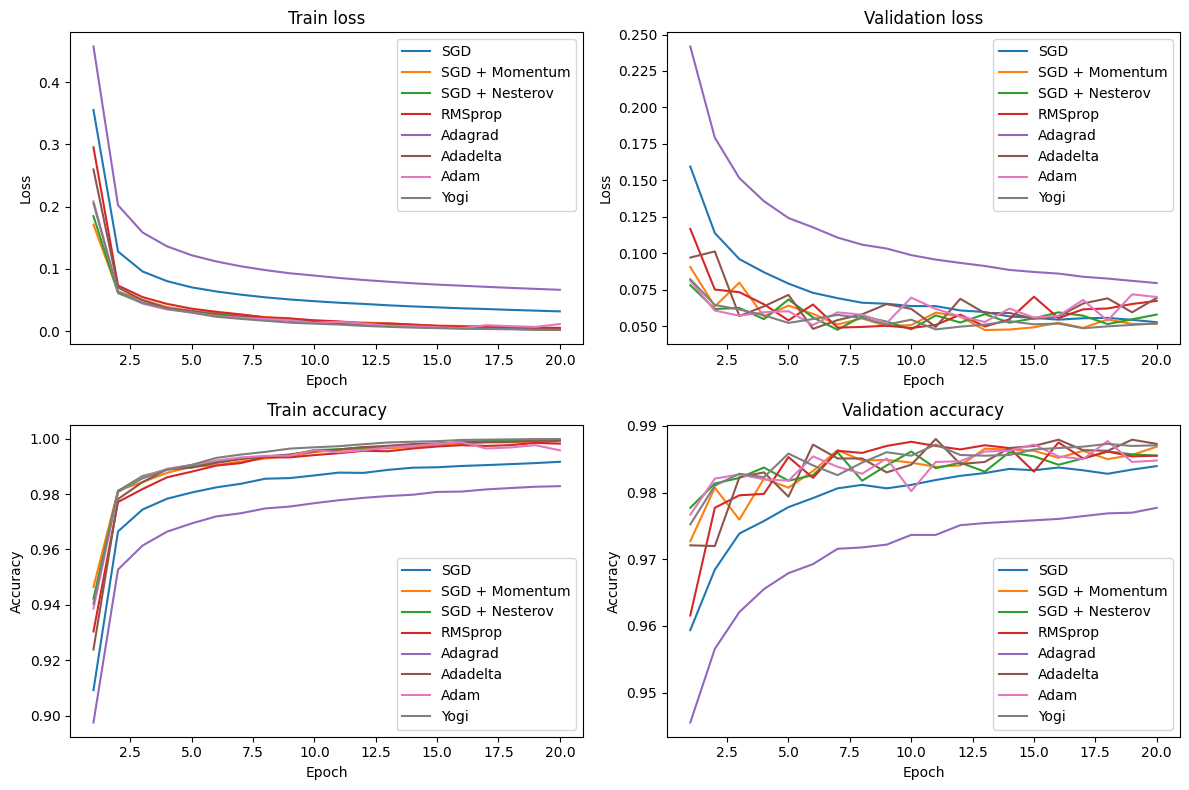

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(1, num_epochs + 1)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Train loss
ax = axes[0, 0]
for opt_name, hist in all_histories.items():
    ax.plot(epochs, hist["train_loss"], label=opt_name)
ax.set_title("Train loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

# 2. Val loss
ax = axes[0, 1]
for opt_name, hist in all_histories.items():
    ax.plot(epochs, hist["val_loss"], label=opt_name)
ax.set_title("Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

# 3. Train accuracy
ax = axes[1, 0]
for opt_name, hist in all_histories.items():
    train_acc = [float(a.cpu()) for a in hist["train_acc"]]
    ax.plot(epochs, train_acc, label=opt_name)
ax.set_title("Train accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

# 4. Val accuracy
ax = axes[1, 1]
for opt_name, hist in all_histories.items():
    train_acc = [float(a.cpu()) for a in hist["val_acc"]]
    ax.plot(epochs, train_acc, label=opt_name)
ax.set_title("Validation accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
plt.tight_layout()
plt.show()

#### Mô tả kết quả thực nghiệm và đánh giá

Các thuật toán cơ sở trong thực nghiệm — bao gồm SGD, SGD + Momentum, SGD + Nesterov, RMSprop và Adagrad — cung cấp một khung tham chiếu về tốc độ hội tụ, độ ổn định và khả năng khái quát hóa. SGD cho quá trình hội tụ chậm hơn nhưng ổn định, đạt val_acc = 0.9840 và test_acc = 0.9860. Momentum và Nesterov cải thiện tốc độ hội tụ rõ rệt, với test_acc lần lượt là 0.9876 và 0.9889, nhưng đường val_loss vẫn có dao động do biên độ cập nhật lớn. RMSprop đạt hiệu năng cao (test_acc = 0.9893) nhưng dao động validation rõ hơn ở cuối quá trình. Adagrad, ngược lại, thể hiện tốc độ hội tụ chậm và hiệu năng thấp nhất trong nhóm cơ sở (test_acc = 0.9810), phù hợp với đặc trưng learning rate giảm nhanh.

Trên nền các kết quả này, ba thuật toán trọng tâm của nhóm nghiên cứu: Adadelta, Adam và Yogi, đều vượt trội hơn hoặc duy trì hiệu năng ngang bằng các thuật toán cơ sở mạnh nhất.

#### Phân tích ba thuật toán thuộc nhóm nghiên cứu

### **1. Adadelta**

Adadelta đạt hiệu năng tốt nhất trong toàn bộ thí nghiệm với **test_acc = 0.9896** và **val_acc = 0.9873**, cao hơn tất cả thuật toán cơ sở.  Train_loss rất thấp (**0.0020**) và train_acc gần tuyệt đối (**0.9995**) cho thấy quá trình tối ưu diễn ra hiệu quả mà không cần điều chỉnh phức tạp về siêu tham số.  
Mặc dù val_loss có dao động nhẹ, Adadelta vẫn duy trì khả năng khái quát hóa tốt nhất. Điều này nhấn mạnh ưu điểm lớn nhất của Adadelta: **ổn định, hiệu năng cao và không nhạy với lựa chọn learning rate.**

---

### **2. Adam**

Adam đạt **test_acc = 0.9878**, vượt hầu hết thuật toán cơ sở và chỉ kém nhẹ RMSprop và Adadelta. Adam cho tốc độ hội tụ rất nhanh ngay từ các epoch đầu, phản ánh hiệu quả của cơ chế thích nghi dựa trên momen bậc nhất và bậc hai.  
Tuy val_loss dao động nhiều hơn Adadelta, Adam vẫn đảm bảo hiệu năng ổn định và khả năng khái quát hóa cao. Điều này phù hợp với vai trò phổ biến của Adam trong thực tế: **tối ưu nhanh, hiệu quả, thích ứng tốt với gradient thay đổi.**

---

### **3. Yogi**

**Yogi**: một biến thể của Adam với cơ chế điều chỉnh momen bậc hai ổn định hơn, thể hiện hiệu năng rất cạnh tranh với **test_acc = 0.9895** và **val_acc = 0.9871**, gần như tương đương Adadelta và vượt trội so với các thuật toán cơ sở. Với train_acc = **0.9999** và train_loss thấp (**0.0024**), Yogi cho thấy khả năng tối ưu nhanh và mạnh mẽ giống Adam nhưng giảm dao động validation, mang lại sự ổn định tốt hơn.  Điều này khẳng định giá trị của Yogi như một mở rộng hiệu quả của Adam cho các bài toán cần **tính ổn định cao hơn**.

### **So sánh ba thuật toán nghiên cứu**

---

### **Adadelta**
- Khả năng khái quát hóa tốt nhất (**test_acc = 0.9896**).  
- Ít phụ thuộc siêu tham số, **ổn định** và **hiệu năng cao**.

---

### **Adam**
- Hội tụ **nhanh nhất**, hiệu năng cao (**test_acc = 0.9878**).  
- Dao động validation lớn hơn Adadelta/Yogi nhưng vẫn trong mức ổn định.

---

### **Yogi**
- Hiệu năng rất cao và ổn định, gần tương đương Adadelta (**test_acc = 0.9895**).  
- Giảm dao động so với Adam; phù hợp cho bài toán cần **tối ưu ổn định** và **hiệu quả**.

### **Kết luận**

So sánh với các thuật toán cơ sở, cả ba thuật toán trong phạm vi nghiên cứu: **Adadelta**, **Adam** và **Yogi** đều thể hiện ưu thế rõ rệt về tốc độ hội tụ, mức độ ổn định và khả năng khái quát hóa. Trong đó:

- **Adadelta** cho hiệu năng tổng thể **tốt nhất**.  
- **Adam** mang lại **tốc độ hội tụ nhanh nhất**.  
- **Yogi** cân bằng giữa **hiệu năng cao** và **độ ổn định**.

Ba thuật toán này đều vượt trội so với các phương pháp tối ưu chuẩn và là lựa chọn phù hợp cho các mô hình yêu cầu **hiệu quả tối ưu hóa cao**.


### Mô hình Deep Residual Networks (ResNet-18)

In [ ]:
torch.manual_seed(0)
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,sampler=train_sampler,batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,sampler=valid_sampler,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1, shuffle=False)

Train data set: 60000
Test data set: 10000


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, input_size, output_size, stride=1, down_sampling=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            input_size, output_size, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_size)
        self.conv2 = nn.Conv2d(output_size, output_size,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_size)
        self.relu = nn.ReLU(inplace=True)
        self.shortcut = nn.Sequential()
        if stride != 1 or input_size != output_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_size, self.expansion * output_size,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * output_size)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, input_size, output_size, stride=1, down_sampling=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(input_size, output_size,
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_size)
        self.conv2 = nn.Conv2d(
            output_size, output_size, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_size)
        self.conv3 = nn.Conv2d(
            output_size, output_size * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(output_size * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.down_sampling = down_sampling
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.down_sampling is not None:
            identity = self.down_sampling(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.input_size = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, output_size, blocks, stride=1):
        down_sampling = None
        if stride != 1 or self.input_size != output_size * block.expansion:
            down_sampling = nn.Sequential(
                nn.Conv2d(self.input_size, output_size * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_size * block.expansion),
            )

        layers = []
        layers.append(
            block(self.input_size, output_size, stride, down_sampling))
        self.input_size = output_size * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.input_size, output_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
%pip install torchinfo
from torchinfo import summary

model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 14, 14]         3,136
├─BatchNorm2d: 1-2                       [128, 64, 14, 14]         128
├─ReLU: 1-3                              [128, 64, 14, 14]         --
├─MaxPool2d: 1-4                         [128, 64, 7, 7]           --
├─Sequential: 1-5                        [128, 64, 7, 7]           --
│    └─BasicBlock: 2-1                   [128, 64, 7, 7]           --
│    │    └─Conv2d: 3-1                  [128, 64, 7, 7]           36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 7, 7]           128
│    │    └─ReLU: 3-3                    [128, 64, 7, 7]           --
│    │    └─Conv2d: 3-4                  [128, 64, 7, 7]           36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 7, 7]           128
│    │    └─Sequential: 3-6              [128, 64, 7, 7]           --
│

In [ ]:
def train_val_model_resnet(model, criterion, optimizer, dataloaders, num_epochs=25, scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print(f"Epoch {epoch+1:02d}/{num_epochs:02d} | "
                  f"train_loss={losses['train'][-1]:.4f} acc={accuracies['train'][-1]:.5f} | "
                  f"val_loss={losses['val'][-1]:.4f} acc={accuracies['val'][-1]:.5f}")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

In [ ]:
optimizer_constructors = {
    "SGD": lambda params: torch.optim.SGD(params, lr=0.01),
    "SGD + Momentum": lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9),
    "SGD + Nesterov": lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True),
    "RMSprop": lambda params: torch.optim.RMSprop(params, lr=learning_rate),
    "Adagrad": lambda params: torch.optim.Adagrad(params, lr=learning_rate),
    "Adadelta": lambda params: torch.optim.Adadelta(params, lr=1.0),
    "Adam": lambda params: torch.optim.Adam(params, lr=learning_rate),
    "Yogi": lambda params: Yogi(params, lr=learning_rate),
}

In [ ]:
def evaluate_testset(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    return acc

In [ ]:
num_epochs = 20
all_histories = {}   # lưu toàn bộ loss/acc theo epoch
_summary = {}         # lưu kết quả cuối cùng (bảng)
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()

for opt_name, opt_fn in optimizer_constructors.items():
    print(f"\n===== Training with {opt_name} =====")

    # Khởi tạo lại model mới cho từng optimizer
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes).to(device)
    optimizer = opt_fn(model.parameters())
    model, losses, accuracies = train_val_model_resnet(model, criterion, optimizer, dataloaders, num_epochs, log_interval=1)

    # Lưu full history
    all_histories[opt_name] = {
        "train_loss": losses["train"],
        "val_loss": losses["val"],
        "train_acc": accuracies["train"],
        "val_acc": accuracies["val"],
    }

    # Tính test_acc nếu có test_loader
    test_acc = None
    test_acc = evaluate_testset(model, test_loader, device)

    # Lưu kết quả cho bảng
    _summary[opt_name] = {
        "train_loss": float(losses["train"][-1]),
        "val_loss": float(losses["val"][-1]),
        "train_acc": float(accuracies["train"][-1]),
        "val_acc": float(accuracies["val"][-1]),
        "test_acc": float(test_acc) if test_acc is not None else None,
    }


===== Training with SGD =====
Epoch 01/20 | train_loss=0.2421 acc=0.93336 | val_loss=0.0863 acc=0.97385
Epoch 02/20 | train_loss=0.0562 acc=0.98401 | val_loss=0.0689 acc=0.98000
Epoch 03/20 | train_loss=0.0291 acc=0.99255 | val_loss=0.0610 acc=0.98229
Epoch 04/20 | train_loss=0.0165 acc=0.99664 | val_loss=0.0564 acc=0.98365
Epoch 05/20 | train_loss=0.0104 acc=0.99805 | val_loss=0.0534 acc=0.98458
Epoch 06/20 | train_loss=0.0064 acc=0.99940 | val_loss=0.0542 acc=0.98438
Epoch 07/20 | train_loss=0.0046 acc=0.99969 | val_loss=0.0533 acc=0.98542
Epoch 08/20 | train_loss=0.0036 acc=0.99979 | val_loss=0.0517 acc=0.98573
Epoch 09/20 | train_loss=0.0029 acc=0.99987 | val_loss=0.0518 acc=0.98583
Epoch 10/20 | train_loss=0.0021 acc=0.99997 | val_loss=0.0531 acc=0.98500
Epoch 11/20 | train_loss=0.0021 acc=0.99987 | val_loss=0.0517 acc=0.98583
Epoch 12/20 | train_loss=0.0018 acc=0.99997 | val_loss=0.0527 acc=0.98594
Epoch 13/20 | train_loss=0.0016 acc=0.99992 | val_loss=0.0518 acc=0.98635
Epoch 1

In [ ]:
import pandas as pd

summary_df = pd.DataFrame.from_dict(_summary, orient="index")
summary_df = summary_df[
    ["train_loss", "train_acc", "val_loss", "val_acc", "test_acc"]
]

summary_df.round(4)

,train_loss,train_acc,val_loss,val_acc,test_acc
SGD,0.0007,1.0000,0.0530,0.9864,0.9870
SGD + Momentum,0.0002,0.9999,0.0448,0.9896,0.9929
SGD + Nesterov,0.0026,0.9990,0.0424,0.9905,0.9919
RMSprop,0.0094,0.9973,0.0544,0.9889,0.9923
Adagrad,0.0005,1.0000,0.0580,0.9845,0.9846
Adadelta,0.0017,0.9996,0.0411,0.9916,0.9936
Adam,0.0087,0.9971,0.0365,0.9918,0.9916
Yogi,0.0013,0.9996,0.0393,0.9918,0.9928


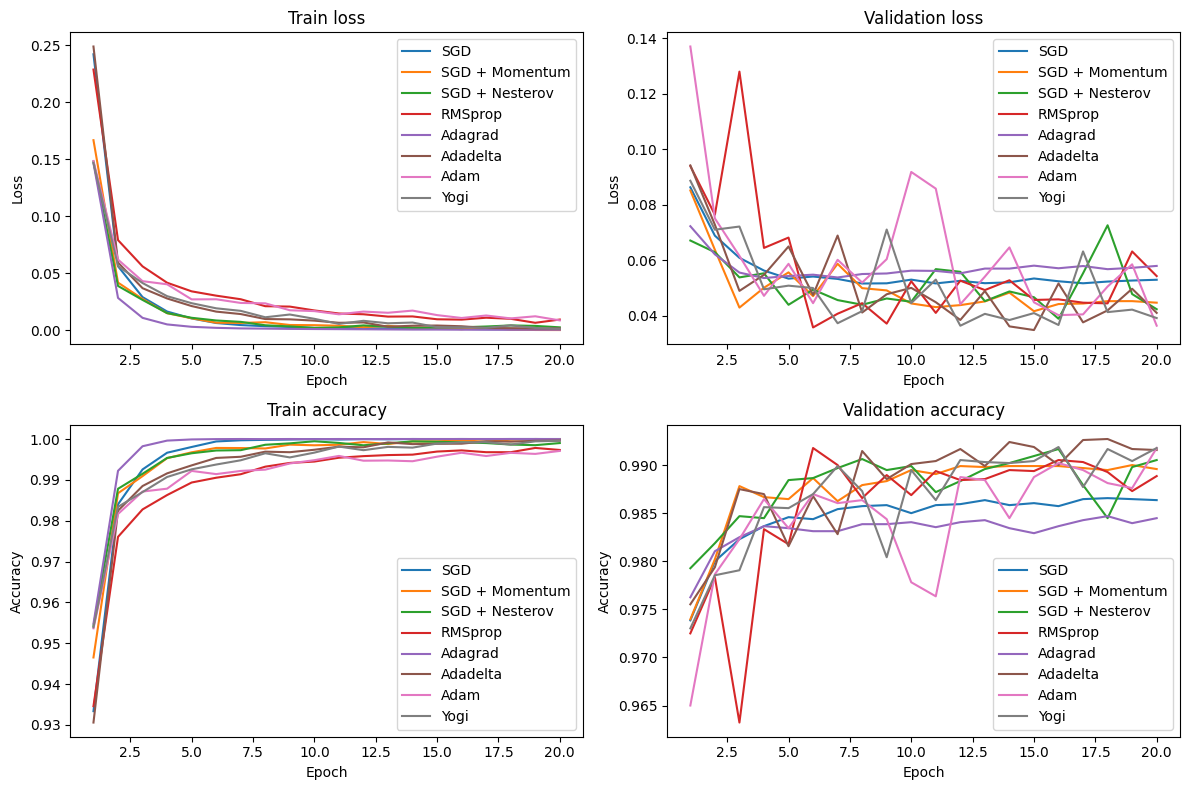

In [ ]:
import matplotlib.pyplot as plt
epochs = np.arange(1, num_epochs + 1)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Train loss
ax = axes[0, 0]
for opt_name, hist in all_histories.items():
    ax.plot(epochs, hist["train_loss"], label=opt_name)
ax.set_title("Train loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

# 2. Val loss
ax = axes[0, 1]
for opt_name, hist in all_histories.items():
    ax.plot(epochs, hist["val_loss"], label=opt_name)
ax.set_title("Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

# 3. Train accuracy
ax = axes[1, 0]
for opt_name, hist in all_histories.items():
    train_acc = [float(a.cpu()) for a in hist["train_acc"]]
    ax.plot(epochs, train_acc, label=opt_name)
ax.set_title("Train accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()

# 4. Val accuracy
ax = axes[1, 1]
for opt_name, hist in all_histories.items():
    train_acc = [float(a.cpu()) for a in hist["val_acc"]]
    ax.plot(epochs, train_acc, label=opt_name)
ax.set_title("Validation accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
plt.tight_layout()
plt.show()

#### Mô tả kết quả thực nghiệm và đánh giá

Kết quả thực nghiệm cho thấy tất cả các thuật toán đều hội tụ rất nhanh và đạt độ chính xác cao trên cả tập huấn luyện và validation. Các phương pháp dựa trên SGD (SGD, SGD + Momentum, SGD + Nesterov) đạt train_acc xấp xỉ 1.0 chỉ sau vài epoch; trong đó, Momentum và Nesterov cải thiện rõ rệt tốc độ giảm loss và đạt best val_acc lần lượt là 0.99000 và 0.99167, cao hơn so với SGD thuần (0.98656). Nhóm thuật toán thích nghi (RMSprop, Adagrad, Adadelta, Adam, Yogi) tiếp tục cho hiệu năng cạnh tranh: Adadelta đạt best val_acc cao nhất 0.99271, trong khi RMSprop, Adam và Yogi đều xấp xỉ 0.9917–0.9919, vượt nhẹ các biến thể SGD có gia tốc. Ngược lại, Adagrad mặc dù hội tụ nhanh và rất ổn định nhưng dừng ở mức val_acc = 0.98469, thấp hơn các thuật toán còn lại. Nhìn chung, so với các thuật toán cơ sở, Adadelta, Adam và Yogi đều cho thấy khả năng tối ưu tốt, hội tụ nhanh và duy trì hiệu năng validation vượt trội hoặc tương đương nhóm phương pháp tốt nhất trong thí nghiệm.